In [1]:
from imaster_paper_args import *

Start_client: No scheduler file, will start local cluster at  ./temp_skylens/pid822158/


In [2]:
from astropy.io import fits
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

import pyccl as ccl
import pymaster as nmt
import healpy as hp

import sys
sys.path.insert(0, '../skylens')
import correction

%load_ext autoreload
%autoreload 2

In [3]:
path = os.path.join(os.path.dirname(os.environ['SCRATCH']), 
                    'share/raytracesim/HSC_S16A/mocks_4zbins')

In [4]:
i = 25
rot = 9
sims = [os.path.join(path, sim) for sim in os.listdir(path) if f'r{i:03d}_rot{rot:02d}' in sim]

In [5]:
sim_dict = {}
for i, sim in enumerate(sims):
    # Remove objects with z = -1
    sim = fits.open(sim)[1].data
    sim = sim[sim['z_source_mock'] != -1]

    # Get z centers and boundary
    z = np.unique(sim['z_source_mock'])
    z_edges = 0.5 * (z[1:] + z[:-1])
    z_edges = np.concatenate([[0], z_edges, [np.max(z)+0.2]])
    dNdz, _ = np.histogram(sim['z_source_mock'], bins=z_edges, density=True)
    sim_dict[i] = {
        'z': z,
        'dNdz': dNdz,
        'ra': sim['ra_mock'],
        'dec': sim['dec_mock'],
        'e1': sim['e1_mock'],
        'e2': sim['e2_mock'],
        'g1': sim['shear1_sim'],
        'g2': sim['shear2_sim']
    }
sim_dict['n_bins'] = len(sim_dict.keys())

In [6]:
# HSC coverage is 1400 sq deg.
full_sky = 4 * np.pi * (180 / np.pi) ** 2
f_sky = 137. / (full_sky)

In [7]:
use_window=True
unit_window=False

do_pseudo_cl=True
do_xi=False

bin_cl=True
bin_xi=True

use_binned_l=False
use_binned_theta=False

store_win=True

In [9]:
shear_zbins=lsst_source_tomo_bins(nbins=sim_dict['n_bins'],use_window=use_window,nside=1024,f_sky=f_sky,unit_win=unit_window)

ns0:  27.0
[0.10002001 0.10082017 0.10162032 ... 2.9981997  2.9989998  2.9998    ] 100 5
source_tomo_bins, zmax 5.0 2.9998 0.59997
Tracer utils has no tracers
skylens will use following default values:  {'yaml_inp_file': None, 'python_inp_file': None, 'l_cl': None, 'Ang_PS': None, 'logger': None, 'tracer_utils': None, 'shear_zbins': None, 'kappa_zbins': None, 'zkernel_func_names': {'shear': 'set_kernel', 'galaxy': 'set_kernel', 'kappa': 'set_kernel'}, 'pk_params': {'non_linear': 1, 'kmax': 30, 'kmin': 0.0003, 'nk': 500, 'scenario': 'dmo', 'pk_func': 'camb_pk_too_many_z', 'halofit_version': 'takahashi'}, 'cosmo_params': {'h': 0.7, 'Omb': 0.046, 'Omd': 0.233, 's8': 0.817, 'Om': 0.279, 'Ase9': 2.1842, 'mnu': 0.06, 'Omk': 0.0, 'tau': 0.06, 'ns': 0.965, 'OmR': 0.0014936944554559178, 'w': -1, 'wa': 0, 'Tcmb': <Quantity 2.7255 K>, 'z_max': 4, 'use_astropy': True, 'Oml': 0.721, 'astropy_cosmo': FlatLambdaCDM(name="Planck18", H0=67.66 km / (Mpc s), Om0=0.30966, Tcmb0=2.7255 K, Neff=3.046, m_nu=

/hildafs/home/andypark/.local/lib/python3.9/site-packages/skylens-0.1-py3.9.egg/skylens/angular_power_spectra.py:33: RuntimeWarning: divide by zero encountered in true_divide


power spectra function:  <bound method Power_Spectra.camb_pk_too_many_z of <skylens.power_spectra.Power_Spectra object at 0x14e24a93cd60>>
Win gen: step size 153 3072 31.0 10 False True
Window done. Size: 0.0


/hildafs/home/andypark/.local/lib/python3.9/site-packages/skylens-0.1-py3.9.egg/skylens/angular_power_spectra.py:123: RuntimeWarning: divide by zero encountered in true_divide


scatter_dict got empty dictionary
cl_tomo, Win: None
cl graph done
gather_dict got empty dictionary


In [11]:
with open('../data/mask.pickle', 'rb') as f:
    mask = pickle.load(f)

In [12]:
for i in range(sim_dict['n_bins']):
    sim = sim_dict[i]
    shear_zbins[i]['z'] = sim['z']
    shear_zbins[i]['dz'] = np.gradient(sim['z'])
    shear_zbins[i]['pz'] = sim['dNdz']
    shear_zbins[i]['pzdz'] = sim['dNdz'] * np.gradient(sim['z'])
    shear_zbins[i]['window'] = mask[i]
    shear_zbins[i]['window_N'] = mask[i]

In [13]:
corrs = [corr_ll]
bi=(0,0)
corr=corrs[0]
s=s1_s2s[corr]
if corr==corr_ll:
    s=(2,-2)

In [14]:
#setup parameters
lmax_cl = 2000 #2000
lmin_cl = 0

l0 = np.arange(lmin_cl, lmax_cl)

window_lmax = lmax_cl

lmin_cl_Bins = 200 #lmin_cl+2
lmax_cl_Bins = lmax_cl - 10
Nl_bins = 25

#l_bins = np.unique(np.int64(np.logspace(np.log10(lmin_cl_Bins), np.log10(lmax_cl_Bins), Nl_bins+1)))
#l_bins = np.arange(lmin_cl_Bins, lmax_cl_Bins, Nl_bins)
l_bins = np.linspace(lmin_cl_Bins, lmax_cl_Bins, Nl_bins)
lb = .5 * (l_bins[1:] + l_bins[:-1])
dl = (l_bins[1:] - l_bins[:-1])
lb_cl = lb * 1.
l_bins_center = lb * 1.
Nl_bins = len(lb)

l = l0

In [15]:
Skylens_kwargs=parse_dict(locals())

Skylens_kwargs['do_pseudo_cl']=True
Skylens_kwargs['do_xi']=False
SL_cl0=Skylens(**Skylens_kwargs)

skylens will use following default values:  {'yaml_inp_file': None, 'python_inp_file': None, 'use_defaults': None, 'l_cl': None, 'Ang_PS': None, 'logger': None, 'kappa_zbins': None, 'galaxy_zbins': None, 'zkernel_func_names': {'shear': 'set_kernel', 'galaxy': 'set_kernel', 'kappa': 'set_kernel'}, 'pk_params': {'non_linear': 1, 'kmax': 30, 'kmin': 0.0003, 'nk': 500, 'scenario': 'dmo', 'pk_func': 'camb_pk_too_many_z', 'halofit_version': 'takahashi'}, 'cosmo_params': {'h': 0.7, 'Omb': 0.046, 'Omd': 0.233, 's8': 0.817, 'Om': 0.279, 'Ase9': 2.1842, 'mnu': 0.06, 'Omk': 0.0, 'tau': 0.06, 'ns': 0.965, 'OmR': 0.0014936944554559178, 'w': -1, 'wa': 0, 'Tcmb': <Quantity 2.7255 K>, 'z_max': 4, 'use_astropy': True, 'Oml': 0.721, 'astropy_cosmo': FlatLambdaCDM(name="Planck18", H0=67.66 km / (Mpc s), Om0=0.30966, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.04897)}, 'WT_kwargs': None, 'WT': None, 'z_PS': None, 'log_z_PS': 2, 'window_l': None, 'Win': None, 'cl_func_names': {('galaxy', 'g

/hildafs/home/andypark/.local/lib/python3.9/site-packages/skylens-0.1-py3.9.egg/skylens/angular_power_spectra.py:33: RuntimeWarning: divide by zero encountered in true_divide


power spectra function:  <bound method Power_Spectra.camb_pk_too_many_z of <skylens.power_spectra.Power_Spectra object at 0x14e2785652b0>>
Win gen: step size 100 2000 2001.0 1 True True
Win not found, computing now
get_Win, total cl keys:  10
set window_cl: cl0,cl_b done 0.00016927719116210938
set window_cl: cl done 0.04409646987915039 0.068 0.0
set_window_cl done 266.01060461997986
wigner_files: {0: '/hildafs/projects/phy200017p/andypark/Skylens_public/temp/wig3j_l5000_w5000_0_reorder.zarr', 2: '/hildafs/projects/phy200017p/andypark/Skylens_public/temp/wig3j_l2200_w4400_2_reorder.zarr'}
wigner done dict_keys([])
setting windows, coupling matrices  <Client: 'tcp://127.0.0.1:42913' processes=1 threads=1, memory=51.56 GiB>
get_coupling_lm_all_win 500
got wig3j 500
done lm 500 96.41630363464355
get_coupling_lm_all_win 1100
got wig3j 1100
done lm 1100 93.7152886390686
get_coupling_lm_all_win 300
got wig3j 300
done lm 300 71.37934136390686
get_coupling_lm_all_win 100
got wig3j 100
done lm 1

In [16]:
SL_cl0.gather_data()

gather_dict got empty dictionary


In [80]:
pcl_t = np.zeros((100, 4, 3072))
for i in range(100):
    fname = f'../sims/pcl_{i}.pickle'
    with open(fname, 'rb') as f:
        d = pickle.load(f)
    for b in range(4):
        pcl_t[i][b] = d[b]

In [73]:
pcl = np.mean(pcl_t, axis=0)
std = np.std(pcl_t, axis=0)

In [81]:
cl_corrected = dict()
for i in range(4):
    for j in range(i, 4):
        fname = f'../data/cl_{i}_{j}.txt'
        ell, cl = np.loadtxt(fname)
        bi = (i, j)
        cl_corrected[bi] = cl

In [82]:
cl_corrected_binned = dict()
for b in range(sim_dict['n_bins']):
    M = SL_cl0.Win['cl'][corr_ll][(b, b)]['M']
    cl_binned = SL_cl0.binning.bin_1d(cl_corrected[(b, b)][:lmax_cl], bin_utils=SL_cl0.cl_bin_utils)
    cl_corrected_binned[b] = cl_binned

In [84]:
cl_sl_binned = dict()
for i in range(100):
    cl_sl_binned[i] = dict()
    for b in range(sim_dict['n_bins']):
        pcl_binned = SL_cl0.binning.bin_1d(pcl_t[i][b][:lmax_cl], bin_utils=SL_cl0.cl_bin_utils)
        M = SL_cl0.Win['cl'][corr_ll][(b, b)]['M']
        wt0 = 1. / cl_corrected[(b, b)][:lmax_cl]
        wt0[:2] = 0
        cl_binned = SL_cl0.binning.bin_1d(cl_corrected[(b, b)][:lmax_cl], bin_utils=SL_cl0.cl_bin_utils)
        M_binned = SL_cl0.binning.bin_2d_coupling(M=M, wt0=wt0, 
                                                 wt_b=cl_binned, bin_utils=SL_cl0.cl_bin_utils)
        cl_sl_binned[i][b] = pcl_binned @ np.linalg.pinv(M_binned)

/tmp/ipykernel_822158/2592846886.py:7: RuntimeWarning: divide by zero encountered in true_divide
  wt0 = 1. / cl_corrected[(b, b)][:lmax_cl]


In [86]:
pcl_t_binned = np.zeros((100, 4, 24))
for i in range(100):
    for b in range(4):
        pcl_t_binned[i][b] = cl_sl_binned[i][b]

In [90]:
pcl_binned_mean = np.mean(pcl_t_binned, axis=0)
pcl_binned_std = np.std(pcl_t_binned, axis=0)

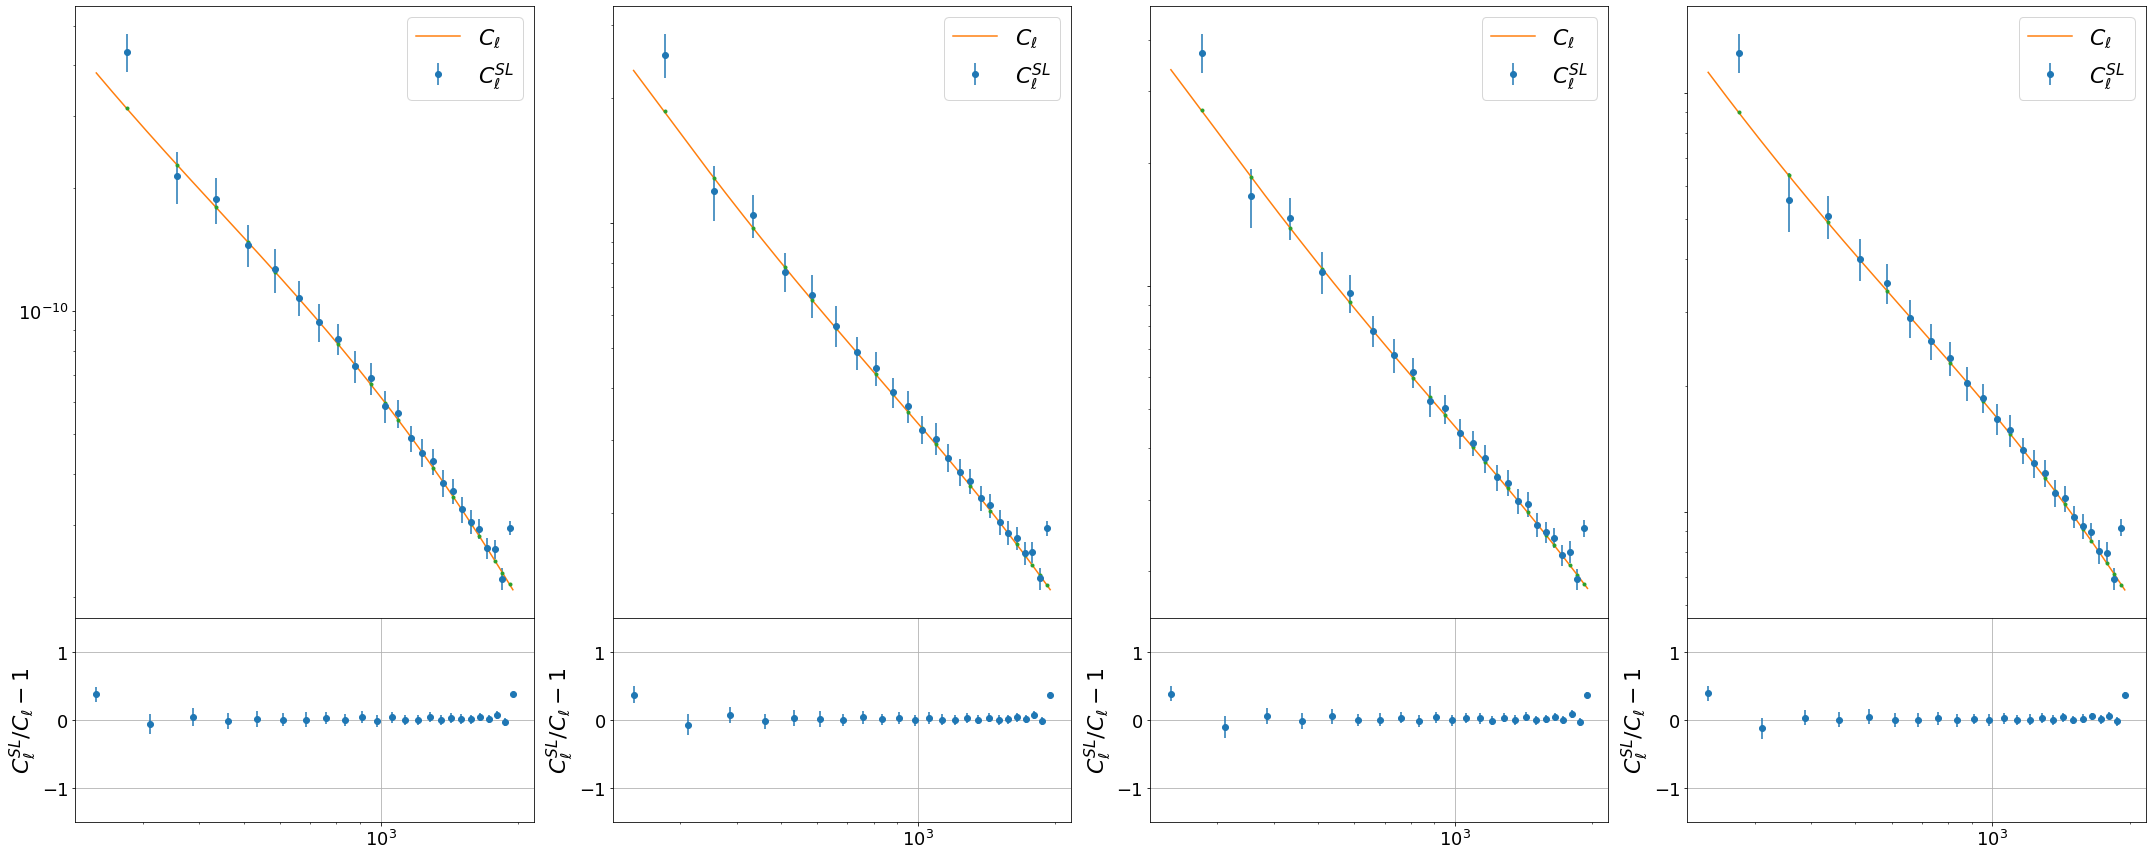

In [98]:
bc = 0.5 * (SL_cl0.l_bins[1:] + SL_cl0.l_bins[:-1])
fig = plt.figure(figsize=(30, 12))
gs = gridspec.GridSpec(2, 4, height_ratios=[3, 1], hspace=0) 
n_bins = sim_dict['n_bins']
for i in range(n_bins):
    ax0, ax1 = plt.subplot(gs[0, i]), plt.subplot(gs[1, i])
    ax0.errorbar(bc, pcl_binned_mean[i], pcl_binned_std[i], fmt='o', ls='None', label=r'$C_\ell^{SL}$')
    ax0.loglog(ell[lmin_cl_Bins:lmax_cl_Bins], cl_corrected[(i, i)][lmin_cl_Bins:lmax_cl_Bins], label=r'$C_\ell$')
    ax0.loglog(bc, cl_corrected_binned[i], '.')
    ax0.tick_params(axis='both', which='major', labelsize=18)
    ax0.tick_params(axis='both', which='minor', labelsize=18)
    ax0.label_outer()
    ax0.legend(fontsize=22)
    
    ax1.errorbar(bc, pcl_binned_mean[i] / cl_corrected_binned[i] - 1, pcl_binned_std[i] / pcl_binned_mean[i], fmt='o', ls='None')
    ax1.set_xscale('log')
    ax1.grid(True)
    ax1.set_ylim(-1.5, 1.5)
    ax1.set_ylabel(r'$C_\ell^{SL} / C_\ell - 1$', fontsize=22)
    ax1.tick_params(axis='both', which='major', labelsize=18)
    ax1.tick_params(axis='both', which='minor', labelsize=18)
plt.tight_layout()